In [1]:
import numpy as np
from cosmoTransitions import generic_potential_1
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special
import seaborn as sns
from scipy import misc


%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (8, 6)  #set default figure size



####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant


####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
data = np.loadtxt( 'satoshi_dof.dat' )[500:3900]
Temperature_d=(data.T)[0]
dof_d=(data.T)[1]#relativistic degrees of freedom  
dof_s=(data.T)[3]#entropic degrees of freedom
g_star = interpolate.interp1d(Temperature_d, dof_d, kind='cubic')
g_star_s = interpolate.interp1d(Temperature_d, dof_s, kind='cubic')


class model1(generic_potential_1.generic_potential):
    def init(self, ms = 50, theta = 0, muhs = 0, u = 100, mu3 = 0):
        self.Ndim = 2
        self.renormScaleSq = v2
        self.ms = ms
        self.theta = theta
        self.muhs = muhs
        self.u = u
        self.mu3 = mu3
        self.lamh = 1/(4*v2)*(mh**2+self.ms**2 + (mh**2 - ms**2)*np.cos(2*self.theta))
        #self.lams = 1/(2*self.u**2)*(mh**2*np.sin(self.theta)**2+self.ms**2*np.cos(self.theta)**2 + self.mu3*self.u + self.muhs*v**2/(2*self.u))
        self.lams = 1/(4*self.u**3)*(mh**2*self.u + ms**2*self.u + 2*self.u**2*self.mu3 + v**2*self.muhs - (mh**2-ms**2)*self.u*np.cos(2*self.theta))
        self.lammix = 1/(v*self.u)*(-(self.ms**2-mh**2)*np.sin(self.theta)*np.cos(self.theta) - self.muhs*v)
        self.muh2 = self.lamh*v2 + self.muhs*self.u + self.lammix/2*self.u**2
        self.mus2 = -self.mu3*self.u + self.lams*self.u**2 + self.muhs*v2/(2*self.u) + self.lammix/2*v2

    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0])
        #return any([np.array([X])[...,0] < -5.0, np.array([X])[...,1] < -5.0])

    def V0(self, X):
        X = np.asanyarray(X)
        h, s = X[...,0], X[...,1]
        pot = -1/2*self.muh2*h**2 + 1/4*self.lamh*h**4 - 1/2*self.mus2*s**2 - 1/3*self.mu3*s**3 + 1/4*self.lams*s**4 + 1/2*self.muhs*h**2*s + 1/4*self.lammix*h**2*s**2
        return pot

    def boson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]

       #####Scalar thermal masses, obtained from appendix of 1702.06124
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)

        ##Scalar mass matrix##
        a=3*h**2*self.lamh + s**2*self.lammix/2 - self.muh2 + s*self.muhs + Pi_h
        b=h**2*self.lammix/2 + 3*s**2*self.lams - 2*s*self.mu3 - self.mus2 + Pi_s
        cc=h*s*self.lammix  + h*self.muhs
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B

        ####Gauge boson masses (Longitudinal)
        mWL = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZL=Ag+Bg
        mPh=Ag-Bg


        M = np.array([m1,m2,g**2*h**2/4,h**2/4*(g**2+g1**2),mWL,mZL])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,4,2 , 2,1]) ##Longitudinal at the end


        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5,1.5,1.5])

        return M, dof, c, Mphys

    def old_boson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]


        #####Scalar thermal masses, obtained from appendix of 1702.06124
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)

        ##Scalar mass matrix##
        a=3*h**2*self.lamh + s**2*self.lammix/2 - self.muh2 + s*self.muhs + Pi_h
        b=h**2*self.lammix/2 + 3*s**2*self.lams - 2*s*self.mu3 - self.mus2 + Pi_s
        cc=h*s*self.lammix  + h*self.muhs
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B

        ####Gauge boson masses
        mW = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZ=Ag+Bg
        mPh=Ag-Bg


        M = np.array([m1,m2,mW,mZ])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,6,3])


        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5])

        return M, dof, c, Mphys


    def fermion_massSq(self, X):
        X = np.array(X)
        h,s = X[...,0], X[...,1]
        mt=h**2/2
        M = np.array([mt])
        Mphys = np.array([v**2/2])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        dof = np.array([12])
        return M, dof, Mphys


    def approxZeroTMin(self):
        # There are generically two minima at zero temperature in this model,
        # and we want to include both of them.

        return [np.array([v,self.u])]

    def theory_consistent(self):
        perturbative_limit=4*np.pi
        perturbativity=self.lamh<=perturbative_limit and self.lams<=perturbative_limit and abs(self.lammix)<=perturbative_limit
        positivity=(self.lamh>0) and (self.lams>0) and (self.lammix>-2*(self.lamh*self.lams)**.5)
        if perturbativity and positivity:
            print("Model is theoretically consistent \n")
            return True
        else:
            print("Model is NOT theoretically consistent \n")
            return False


    def print_couplings(self):
        print("Potential parameters are given by \n ")
        print("mus2=",self.mus2, "muh2=",self.muh2,"lamh=",self.lamh,"lams=",self.lams,"lammix=",self.lammix,"\n")
        print("Model parameters are \n")
        print("ms=",self.ms,"theta=",self.theta,"muhs=",self.muhs,"u=",self.u,"mu3=",self.mu3,"\n")

    def isEWSB(self):
        """Method to find the deepest minima of the potential at T=0.
        Doesn't work for Z_2 symmetric potential!!!"""
        n=100
        X_EW=np.array([v,self.u])
        minima=[]
        if self.muhs==0 and self.mu3==0:
            print("Model has a Z2 symmetry in the potential \n")
            print("isEWSB=True \n")
            return True
        #------------
        X0=self.findMinimum([0,100],0)
        if self.Vtot(X0,0)<=self.Vtot(X_EW,0) and abs(abs(X0[0])-v)>10 and abs(self.Vtot(X0,0)-self.Vtot(X_EW,0))>1:
            print("Global minimum found at X=",X0,"\n")
            print("isEWSB=False \n")
            return False
        X0=self.findMinimum([0,-100],0)
        if m.Vtot(X0,0)<=m.Vtot(X_EW,0) and abs(abs(X0[0])-v)>10 and abs(self.Vtot(X0,0)-self.Vtot(X_EW,0))>1:
            print("Global minimum found at X=",X0,"\n")
            print("isEWSB=False \n")
            return False
         
        ###This loop search for a global minima randomly
        for i in range(n):
            x1=np.random.uniform(-100,4*self.Tmax)
            x2=np.random.uniform(-4*self.Tmax,4*self.Tmax)
            X0=self.findMinimum([x1,x2], T=0.0)
            if self.Vtot(X0,0)<=self.Vtot(X_EW,0) and abs(X0[0])-v>10 and abs(self.Vtot(X0,0)-self.Vtot(X_EW,0))>1e2:
                print("Global minimum found at X=",X0,"\n")
                print("isEWSB=False \n")
                return False
        print("isEWSB=True \n")
        return True




def alpha_GW(Tnuc,Drho):
    ####This code gives the parameter alpha relevant for stochastic GW spectrum
    ##AS APPEAR IN FORMULA (8.2) OF 1912.12634
    num_dof=g_star(Tnuc)
    radiationDensity=np.pi**2/30*num_dof*Tnuc**4
    latentHeat=Drho
    return latentHeat/radiationDensity


def trans_class(SymNR):
    """Classify the transition according to the following characteristics:
    ---------
    phi-sym: transition happens in the s-field direction
    phi-symNR: transition happens in the s-field direction (symmetry is not restored at T=1000)
    """
    SNR="sym"
    if SymNR==True:
        SNR="SNR"

    if dh>10 and ds>10:
        return "hs-"+SNR
    elif dh>10 and ds<1:
        return "h-"+SNR
    elif ds>10 and dh<1:
        return "s-"+SNR
    else:
        return "none"+SNR

def beta_GW(Tnuc,dS_TdT):
    ###This code defines the parameter beta relevant for stochastic GW spectrum
    beta=Tnuc*dS_TdT
    return beta

def S_profile(T,elem):
    """This function calculates the Euclidean action from a model m at temperature T
    after knowing its phase history. If more than one FOPT is found it uses "elem" from the list. 
    """
    profile=elem["instanton"].profile1D
    alpha_ode=2
    temp=T
    r, phi, dphi, phivector = profile.R, profile.Phi, profile.dPhi, elem["instanton"].Phi
    phi_meta=elem["high_vev"]
    # Find the area of an n-sphere (alpha=n):
    d = alpha_ode+1  # Number of dimensions in the integration
    area = r**alpha_ode * 2*np.pi**(d*.5)/special.gamma(d*.5) ##4 pi r^2 the surface of a sphere
    # And integrate the profile
    integrand = 0.5 * dphi**2 + m.Vtot(phivector,temp) - m.Vtot(phi_meta,temp)
    integrand *= area
    S = integrate.simps(integrand, r)
    # Find the bulk term in the bubble interior
    volume = r[0]**d * np.pi**(d*.5)/special.gamma(d*.5 + 1)
    S += volume * (m.Vtot(phivector[0],temp) - m.Vtot(phi_meta,temp))

    return S/T

#####
def my_getPhases(m):
    myexps=[(-5,-3),(-5,-5),(-5,-4),(-3,-3)]
    for nord in myexps:
        print("doing",nord)
        try:
            m.getPhases(tracingArgs={"dtstart":10**(nord[0]), "tjump":10**(nord[1])})
            phases_out=m.phases
        except:
            phases_out={}
        finally:
            if len(phases_out)>1:
                break
    return phases_out



def find_nucleation(m):
    """Find min and max temperatures to search for nucleation. IT will be used by bisection method.
    Parameters
        ----------
        m: a model instance. In this case m=model1(kk=1/600**2) for example.
    Returns
        -------
        nuc_dict: a dictionary containing the relevant temperatures and phases indexes. 
                It will be used by the other methods to find the nucleation and percolation parameters  
    """
    if m.phases is None:
        try:
            #phases_dict=m.getPhases()
            #phases_dict=m.getPhases(tracingArgs={"dtstart":1e-3, "tjump":1e-3})
            #phases_dict=m.getPhases(tracingArgs={"dtstart":1e-5, "tjump":1e-4})
            phases_dict=my_getPhases(m)
        except:
            return {}
    else:
        phases_dict=m.phases
    if len(phases_dict)<=1:
        return {}
    from cosmoTransitions import transitionFinder as tf
    crit_temps=tf.findCriticalTemperatures(phases_dict, m.Vtot)
    Num_relevant_trans=0
    ###DETERMINE IF THERE COULD BE TWO-STEP FOPTs
    my_dicts=[]
    for elem in crit_temps:
        if elem["trantype"]==1 and (abs(elem["low_vev"][0]-elem["high_vev"][0])>10 or abs(elem["low_vev"][1]-elem["high_vev"][1])>10):
            print("Tunneling is relevant from phase " + str(elem["high_phase"])+ " to " + str(elem["low_phase"])  )
            Tmax=elem["Tcrit"]
            Tmin=phases_dict[elem["high_phase"]].T[0]
            print("high_vev", elem["high_vev"])
            print("low_vev", elem["low_vev"])
            print("max temperature is", Tmax)
            print("min temperature is", Tmin)
            Num_relevant_trans+=1
            high_phase_key=elem["high_phase"]
            low_phase_key=elem["low_phase"]
            dict_output= {"Tmin":Tmin, "Tmax":Tmax, "high_phase": high_phase_key,"low_phase": low_phase_key}
            my_dicts.append(dict_output)   
            
            X0=m.phases[dict_output["high_phase"]].X[0]
            T0=m.phases[dict_output["high_phase"]].T[0]
            stable=not np.any(np.linalg.eig(m.d2V(X0,T0))[0]<=0)
            
            def findminT(T):
                """Function to find the minimum temperature at which the high_vev coexists. 
                Written in form for optimization"""
                Xmin=m.findMinimum(X0,T)
                dx=np.sum((Xmin-X0)**2)**0.5
                stable=not np.any(np.linalg.eig(m.d2V(Xmin,T))[0]<=0)
                if stable==False or (dx<1) == False or T<0:
                    return 5000
                else:
                    return  T
            Tmin_opt=optimize.fminbound(findminT,0,T0) 
            dict_output["Tmin"]=Tmin_opt
        else: 
            continue
        
    return my_dicts

##DEFINE Nucleation FUNCTION (TO BE OPTIMIZED)
def nucleation_temp(T):
    """DEFINE Nucleation FUNCTION (TO BE OPTIMIZED)
    """
    from cosmoTransitions import transitionFinder as tf
    try:
        S=tf._tunnelFromPhaseAtT(T=T, phases=m.phases, start_phase=m.phases[nuc_dict["high_phase"]], V=m.Vtot, 
                                 dV=m.gradV,phitol=1e-15, overlapAngle=45, nuclCriterion=lambda S,T: Gamma_Hubble4(S,T)-Hubble_total(T)**4,
                                 fullTunneling_params={}, verbose=True, outdict={})
    except:
        return 1e+100
    
    if np.isnan(S):
        return 1e+100
    else:
        return S**2
    
def Hubble_vacuum(T):
    """Hubble parameter for matter density alone. Second term in formula 2.6 of 1809.08242 """
    if m.phases is None:
        phases_dict=m.getPhases()
    else:
        phases_dict=m.phases
    if T<nuc_dict["Tmin"] or T>nuc_dict["Tmax"]:
        return 0
    from cosmoTransitions import transitionFinder as tf
    crit_temps=tf.findCriticalTemperatures(phases_dict, m.Vtot)
    Delta_V=0.0
    for tran_barrier in crit_temps:
        if tran_barrier["trantype"] ==2:
            continue
        ###LOOKS FOR TWO-STEP TRANSITIONS
        #elif T>tran_barrier["Tcrit"] or ((abs(tran_barrier["high_vev"][0]-tran_barrier["low_vev"][0])<1) and (abs(tran_barrier["high_vev"][1]-tran_barrier["low_vev"][1])<1)):
        elif T>tran_barrier["Tcrit"]: ##This is redundant
            continue
        else:
            V_high=m.Vtot(phases_dict[tran_barrier["high_phase"]].valAt(T),T)
            V_low=m.Vtot(phases_dict[tran_barrier["low_phase"]].valAt(T),T)
            if V_high>V_low: 
                Delta_V += V_high - V_low

    return (Delta_V/3)**0.5/Mplanck

def Hubble_radiation(T):
    num_dof=g_star(T)
    Hubble_rad_squared=num_dof*np.pi**2/90*T**4/Mplanck**2
    return Hubble_rad_squared**.5

def Hubble_total(T):
    num_dof=g_star(T)
    Hubble_rad_squared=num_dof*np.pi**2/90*T**4/Mplanck**2
    return (Hubble_rad_squared+Hubble_vacuum(T)**2)**0.5


def Gamma_Hubble4(S,T):
    """Nucleation probability per Hubble volume, including matter contribution. 
    Integrand in formula (2.2) 1809.08242 """
    Gamma1=T**4*np.exp(-S/T)*np.sqrt((S/2/np.pi/T))**3
    return Gamma1

##DEFINE ACTION FUNCTION
def my_Action(T):
    """Calculates S/T at T"""
    from cosmoTransitions import transitionFinder as tf
    try:
        S=tf._tunnelFromPhaseAtT(T=T, phases=m.phases, start_phase=m.phases[nuc_dict["high_phase"]], V=m.Vtot, 
                             dV=m.gradV, phitol=1e-15, overlapAngle=45, nuclCriterion=lambda S,T: S/T ,
                             fullTunneling_params={}, verbose=True, outdict={})
    except:
        S=np.inf
    return S



####This codes the GW signal and SNR given T,alpha, beta and vw. 
LISA_data = np.loadtxt( 'PLS_ESACallv1-2_04yr.txt' )
LISA_data=LISA_data[::20]
LISA_noise=LISA_data[::,0::2]
LISA_data=LISA_data[::,0::3]


def GW_signal_old(Temp,alpha,beta,vel):
    f_redshift=1.65*10**(-5)*(Temp/100)*(g_star(Temp)/100)**(1/6)
    Omega_redshift=1.67*10**(-5)*(100/g_star(Temp))**(1/3)
    kappa_sw=alpha/(0.73+0.083*alpha**0.5+alpha)
    Uf=(3/4*alpha/(1+alpha)*kappa_sw)**0.5
    HR=(8*np.pi)**(1/3)*max(vel,cs)/beta
    HRb=(vel-cs)/vel*HR
    Htau_sw=HR/Uf
    S_fun=lambda s:s**3*(7/(4+3*s**2))**(7/2)
    Omega_sw=3*0.687*Omega_redshift*(1-1/(1+2*HR/Uf)**0.5)*(kappa_sw*alpha/(1+alpha))**2*0.012*HR/cs
    f_sw=f_redshift*(2.6/1.65)*(1/HR)
    GW_tab=[Omega_sw*S_fun(f/f_sw) for f in LISA_noise[::,0]]
    return np.array([LISA_noise[::,0],GW_tab])

def SNR_GW_old(Temp,alpha,beta,vel):
    time=4
    f_redshift=1.65*10**(-5)*(Temp/100)*(g_star(Temp)/100)**(1/6)
    Omega_redshift=1.67*10**(-5)*(100/g_star(Temp))**(1/3)
    kappa_sw=alpha/(0.73+0.083*alpha**0.5+alpha)
    Uf=(3/4*alpha/(1+alpha)*kappa_sw)**0.5
    HR=(8*np.pi)**(1/3)*max(vel,cs)/beta
    HRb=(vel-cs)/vel*HR
    Htau_sw=HR/Uf
    S_fun=lambda s:s**3*(7/(4+3*s**2))**(7/2)
    Omega_sw=3*0.687*Omega_redshift*(1-1/(1+2*HR/Uf)**0.5)*(kappa_sw*alpha/(1+alpha))**2*0.012*HR/cs
    f_sw=f_redshift*(2.6/1.65)*(1/HR)
    integral=np.sum([(LISA_noise[i+1][0]-LISA_noise[i][0])/2*(Omega_sw*S_fun(LISA_noise[i][0]/f_sw)/(LISA_noise[i][1]))**2 for i in range(0,len(LISA_noise)-1)])
    return (time*3.15*10**7*integral)**0.5


def r_comoving(T,T1):
    """Comoving size of a bubble nucleated at T' after growing until T"""
    vw=1
    T_range=np.linspace(T,T1)
    T_half=(T_range[1:]+T_range[:-1])/2
    T_diff=(T_range[1:]-T_range[:-1])
    Hubble_range=[1/Hubble_total(Temp) for Temp in T_half]
    integral=np.sum(np.array(Hubble_range)*T_diff)
    return vw*integral

def Gamma(T):
    """This function gives the nucleation rate at finite temperature """
    try:
        S_action=my_Action(T)*T
    except:
        S_action=np.inf
    if S_action==np.inf:
        return 0
    Gamma1=T**4*np.exp(-S_action/T)*np.sqrt((S_action/2/np.pi/T))**3
    return Gamma1


def I_volume_fraction_integrand(T,T1):
    """For given temperatures T1>T, it calculates the integrand of the volume fraction.
    Includes the factor 4pi/3."""
    if T>T1:
        print("incorrect setting of temperatures")
        return 
    Gam=Gamma(T1)/Hubble_total(T1)/T1**4
    if Gam==0:
        return 0
    r_vol=r_comoving(T,T1)
    if r_vol==0:
        return 0
    output=Gam*r_vol**3
    return 4*np.pi/3*output

def I_volume_fraction(T,vw):
    """For given temperature T. It calculates the volume fraction doing the integral of I_volume_fraction_integrand
    starting from T until the critial temperature found by nucleation_temp ("Tmax")"""
    n=20 ###This number should be changed on a case by case basis
    t_range=np.linspace(T,nuc_dict["Tmax"],n)
    I_list=[]
    for tempi in t_range:
        x=I_volume_fraction_integrand(T,tempi)
        I_list.append(x)
    fun_inter=interpolate.interp1d(t_range,I_list)
    result = integrate.quad(lambda Tx: fun_inter(Tx),t_range[0], t_range[-1])
    return vw**3*result[0]-0.34




def kappa(xi_w,alpha):
    """
    Fit for the efficiency factor 
    """
    c_s         = 1./np.sqrt(3.)
    #kappa_A     = xi_w**1.2 * 6.9*alpha/(1.39-0.0037*np.sqrt(alpha)+alpha)
    kappa_A     = xi_w**1.2 * 6.9*alpha/(1.36-0.037*np.sqrt(alpha)+alpha)
    #kappa_B     = alpha**0.4/(0.0017+(0.997+alpha)**0.4)
    kappa_B     = alpha**0.4/(0.017+(0.997+alpha)**0.4)
    #kappa_C     = np.sqrt(alpha)/(0.135+np.sqrt(0.98)+alpha)
    kappa_C     = np.sqrt(alpha)/(0.135+np.sqrt(0.98+alpha))
    #kappa_D     = alpha/(0.75+0.085*np.sqrt(alpha)+alpha)
    kappa_D     = alpha/(0.73 + 0.083*np.sqrt(alpha)+alpha)
    delta_kappa = -0.9*np.log(np.sqrt(alpha)/(1.+np.sqrt(alpha)))
    xi_w_J      = (np.sqrt(2./3.*alpha+alpha**2)+1./np.sqrt(3.))/(1.+alpha)

    if xi_w < c_s:
    # deflagration
        return c_s**2.2 * kappa_A * kappa_B / ( (c_s**2.2 - xi_w**2.2 )*kappa_B + xi_w * c_s**1.2 * kappa_A )
    elif xi_w < xi_w_J:
    # hybrid
        return (
            kappa_B
            + (xi_w -c_s)*delta_kappa
            + (xi_w-c_s)**3/(xi_w_J-c_s)**3 * ( kappa_C - kappa_B - (xi_w_J-c_s)*delta_kappa )
        )
    #else:
    # detonation
    return (xi_w_J-1.)**3 * (xi_w_J/xi_w)**2.5 * kappa_C * kappa_D / (
        ( (xi_w_J-1.)**3 - (xi_w-1.)**3 ) * xi_w_J**2.5 * kappa_C
        + (xi_w-1.)**3 * kappa_D
    )




def T_percolation(n,vw):
    """Having Tnuc it computes the percolation temperature using I=0.34 as optimization criteria."""
    t_range=np.linspace(nuc_dict["Tmin"],Tnuc,n)[::-1]
    I_list=[]
    t_range_1=[]
    for temp in t_range:
        x=I_volume_fraction(temp,vw)
        I_list.append(x)
        t_range_1.append(temp)
        if x>10:
            break
    fun_inter=interpolate.interp1d(t_range_1,I_list)
    def f_opt(t): 
        try: 
            return fun_inter(t)**2 
        except: 
            return 1e+100
    Tp = optimize.fmin(f_opt,(t_range_1[0]+t_range_1[-1])*0.5,xtol=0.0001)[0]
    volume_shrinks=Tp*misc.derivative(fun_inter, x0=Tp, dx=1e-5, n=1)<-3
    print("The physical volunme diminishes at Tp:",volume_shrinks)
    plt.plot(t_range_1,fun_inter(t_range_1))
    plt.ylim(-1,1)
    plt.axhline(y=0)
    plt.xlabel("$T (GeV)$")
    plt.title("$I(T)-0.34$")
    plt.show()
    return Tp,volume_shrinks


LISA_curve=pd.read_csv("LISA_integrated_curve.csv",index_col=[0])
def GW_signal(Temp,alpha,beta,vel):
    HR=(8*np.pi)**(1/3)*max(vel,cs)/beta ##eqn. (7.5)
    f_sw=2.6*1e-5/HR*(Temp/100)*(g_star(Temp)/100)**(1/6) ##eqn. (7.3)
    Sw = lambda f: (f/f_sw)**3*(4/7 + 3/7*(f/f_sw)**2)**(-7/2) ##eqn. (7.2)
    Uf=np.sqrt(3/4*alpha/(1+alpha)*kappa(vel,alpha))##eqn. (7.4)
    tauH = HR/Uf ##eqn. (7.4)
    prefactor=4.13*1e-7*HR*(1-1/np.sqrt(1+2*tauH))*(kappa(vel,alpha)*alpha/(1+alpha))**2 ##eqn. (7.1)
    Omega=lambda f: prefactor*(100/g_star(Temp))**(1/3)*Sw(f) ##eqn. (7.1)
    f_range=LISA_curve.f
    GW_tab=[Omega(f) for f in f_range]
    return np.array([list(f_range), list(GW_tab)])

def SNR_GW(signal):
    """Computes SNR given signal (f,Omega)"""
    time=4
    f,Om=signal
    Om=np.array(Om)
    On=np.array(LISA_curve.Omega_noise)
    integral=integrate.simps(Om**2/On**2,f)
    return (time*3.15*10**7*integral)**0.5
   

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Compute the transition of model(s)

In [2]:
# df=pd.read_csv("SCANS/BAU/Z2_breaking_sols_BAU.csv",index_col=[0]).sort_values("alpha_max").drop_duplicates()
# df=df[df.Tnuc_0>df.dT_0]
# 
# modi=-1
# ms_val=df.iloc[modi]["ms"]
# theta_val=df.iloc[modi]["theta"]
# u_val=df.iloc[modi]["u"]
# mu3_val=df.iloc[modi]["mu3"]
# muhs_val=df.iloc[modi]["muhs"]
# 
# 
# 
# m=model1(ms = ms_val, theta = theta_val,muhs= muhs_val ,u = u_val,mu3 = mu3_val)
# 
# m.print_couplings()
# thbool=m.theory_consistent()
# EWSBbool=m.isEWSB()
# 
# Pih=g1**2/16 + 3*g**2/16 + m.lamh/2 + 1/4 + m.lammix/24
# Pis=m.lammix/6 + m.lams/4
# lamh_tilde=m.lamh - m.lammix**2/4/m.lams
# dict_out={'ms':m.ms,'theta':m.theta, 'u':m.u,"muhs":m.muhs,"mu3":m.mu3,
#       "lamh":m.lamh,"lams":m.lams,"lammix":m.lammix,
#       "muh2":m.muh2,"mus2":m.mus2,
#       "Pih":Pih,"Pis":Pis,"lamh_tilde":lamh_tilde}
# dict_out.update({ "th_bool":thbool and EWSBbool})
# if thbool==True and EWSBbool==True:
#     try:
#         alltrans=m.findAllTransitions()
#         index=0
#         count_trans=0
#         alpha_list=[]
#         dT_list=[]
#         trans_types=[]
#         for elem in alltrans:
#             if elem["trantype"]==1:
#                 count_trans+=1
#                 phi_stable=elem["low_vev"]
#                 phi_meta=elem["high_vev"]
#                 SymNR=np.sum(m.findMinimum([0,0],1000)**2)**0.5>10
#                 dh,ds=abs(phi_meta-phi_stable)
#                 trans_types.append(trans_class(SymNR))
#                 Tnuc=elem["Tnuc"]
#                 #Tc=elem["crit_trans"]["Tcrit"]
#                 dT=abs(m.phases[elem["high_phase"]].T[0]-m.phases[elem["low_phase"]].T[-1])
#                 dT_list.append(dT)
#                 Delta_rho=m.energyDensity(phi_meta,Tnuc,include_radiation=True)-m.energyDensity(phi_stable,Tnuc,include_radiation=True)
#                 alpha=alpha_GW(Tnuc,Delta_rho)
#                 dS_TdT_Tnuc=misc.derivative(S_profile, x0=Tnuc, dx=.01, n=1, args=(elem,),order=7)
#                 beta_Tnuc=beta_GW(Tnuc,dS_TdT_Tnuc)
#                 alpha_list.append(alpha)
#                 Delta_pressure=m.Vtot(phi_meta,Tnuc) -m.Vtot(phi_stable,Tnuc)
#                 vwformula=(Delta_pressure/Delta_rho)**0.5
#                 xi_Jouguet=((alpha*(2+3*alpha))**0.5+1)/(3**0.5*(1+alpha))
#                 v_calculable=vwformula<xi_Jouguet
#                 dict_out.update({ "h_low_"+str(index):phi_stable[0],"s_low_"+str(index):phi_stable[1],
#                                  "h_high_"+str(index):phi_meta[0],"s_high_"+str(index):phi_meta[1],
#                                  "Tnuc_"+str(index):Tnuc,"dT_"+str(index):dT,
#                                  "alpha_"+str(index):alpha,"beta_"+str(index):beta_Tnuc,
#                                 "vwf_"+str(index):vwformula,"xi_J_"+str(index):xi_Jouguet,
#                                  "v_calculable_"+str(index):vwformula<xi_Jouguet})
#                 index+=1
#         relevant_index=alpha_list.index(max(alpha_list))
#         dict_out.update({"num_FOPT":count_trans,"alpha_max":max(alpha_list),
#                          "dT_max":dT_list[relevant_index],
#                          "tran_type":trans_types[relevant_index]})
# 
#     except:
#         print("error ocurred")
#



In [3]:
def findTnuc():
    fun_nucleation=lambda T: (Gamma(T)/Hubble_total(T)**4-1.)**4
    if nuc_dict["Tmin"]<1:
        Tnuc=optimize.fminbound(fun_nucleation,np.mean([nuc_dict["Tmin"]+1e-3,nuc_dict["Tmax"]]),nuc_dict["Tmax"])
    else:
        Tnuc=optimize.fminbound(fun_nucleation,nuc_dict["Tmin"]+1e-3,nuc_dict["Tmax"])   
    S_nuc=my_Action(Tnuc)
    check_nucleation=abs(Gamma_Hubble4(S_nuc*Tnuc,Tnuc)/Hubble_total(Tnuc)**4-1)<1e-3
    if check_nucleation==True:
        return Tnuc, S_nuc, True
    else:
        Tnuc=optimize.fminbound(nucleation_temp,nuc_dict["Tmin"],nuc_dict["Tmax"])
    S_nuc=my_Action(Tnuc)
    check_nucleation=abs(Gamma_Hubble4(S_nuc*Tnuc,Tnuc)/Hubble_total(Tnuc)**4-1)<1e-3
    if check_nucleation==True:
        return Tnuc, S_nuc, True
    else:
        return None, None, False

-15
Potential parameters are given by 
 
mus2= -37177.192272365704 muh2= -960.5495740029783 lamh= 0.12907900489972074 lams= 1.3795836447601408 lammix= 0.9223176380260567 

Model parameters are 

ms= 130.58690892147837 theta= -0.02057874876051395 muhs= -127.29650034376932 u= 138.14540209753923 mu3= 459.8860354450589 

Model is theoretically consistent 

isEWSB=True 

doing (-5, -3)
Tracing phase starting at x = [246.2000028  138.14540286] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
..........................................................................................................................................
Tracing phase starting at x = [4.71874853e-06 6.43768517e+00] ; t = 125.68236213544652
Tracing minimum down
traceMinimum t0 = 125.682
.......................................................
Tracing minimum up
traceMinimum t0 = 125.682
...............................................................................................................................
Tracing

Path deformation converged. 1 steps. fRatio = 1.66718e-02
Tunneling from phase 2 to phase 0 at T=48.32714
high_vev = [2.66622666e-06 1.04386560e+00]
low_vev = [244.45649269 138.02799003]
Path deformation converged. 36 steps. fRatio = 1.83294e-02
Path deformation converged. 14 steps. fRatio = 1.32097e-02
Path deformation converged. 1 steps. fRatio = 1.66718e-02
Tunneling from phase 2 to phase 0 at T=52.94352
high_vev = [-3.40518381e-06  1.13243078e+00]
low_vev = [243.61137364 137.97009224]
Path deformation converged. 35 steps. fRatio = 1.94137e-02
Path deformation converged. 13 steps. fRatio = 1.70717e-02
Path deformation converged. 1 steps. fRatio = 1.66398e-02
Tunneling from phase 2 to phase 0 at T=69.67126
high_vev = [1.15813542e-05 1.64339832e+00]
low_vev = [238.34673377 137.59223372]
Path deformation converged. 33 steps. fRatio = 1.87662e-02
Path deformation converged. 11 steps. fRatio = 1.72671e-02
Path deformation converged. 1 steps. fRatio = 1.91792e-02
Tunneling from phase 2 to

Path deformation converged. 1 steps. fRatio = 1.66723e-02
Tunneling from phase 2 to phase 0 at T=48.32663
high_vev = [1.38209026e-05 1.04385762e+00]
low_vev = [244.4565767  138.02799515]
Path deformation converged. 36 steps. fRatio = 1.83284e-02
Path deformation converged. 14 steps. fRatio = 1.32101e-02
Path deformation converged. 1 steps. fRatio = 1.66721e-02
Tunneling from phase 2 to phase 0 at T=48.32666
high_vev = [1.13819513e-05 1.04385817e+00]
low_vev = [244.45657002 138.02799396]
Path deformation converged. 36 steps. fRatio = 1.82403e-02
Path deformation converged. 14 steps. fRatio = 1.32117e-02
Path deformation converged. 1 steps. fRatio = 1.66822e-02
Tunneling from phase 2 to phase 0 at T=48.32665
high_vev = [1.52355072e-05 1.04385773e+00]
low_vev = [244.4565726  138.02799528]
Path deformation converged. 36 steps. fRatio = 1.82403e-02
Path deformation converged. 14 steps. fRatio = 1.32117e-02
Path deformation converged. 1 steps. fRatio = 1.66822e-02
Tunneling from phase 2 to p

Path deformation converged. 34 steps. fRatio = 1.99837e-02
Path deformation converged. 13 steps. fRatio = 1.43062e-02
Path deformation converged. 1 steps. fRatio = 1.25222e-02
Tunneling from phase 2 to phase 0 at T=76.35387
high_vev = [4.70687357e-06 1.94577586e+00]
low_vev = [235.07935579 137.33604557]
Path deformation converged. 38 steps. fRatio = 1.85573e-02
Path deformation converged. 13 steps. fRatio = 1.29842e-02
Path deformation converged. 1 steps. fRatio = 1.15149e-02
Tunneling from phase 2 to phase 0 at T=78.9018
high_vev = [-1.81960463e-06  2.07765499e+00]
low_vev = [233.62957277 137.21592433]
Path deformation converged. 41 steps. fRatio = 1.73068e-02
Path deformation converged. 12 steps. fRatio = 1.92766e-02
Path deformation converged. 1 steps. fRatio = 1.60583e-02
Tunneling from phase 2 to phase 0 at T=81.44973
high_vev = [-1.26983211e-05  2.21909867e+00]
low_vev = [232.05909192 137.08090615]
Path deformation converged. 41 steps. fRatio = 1.76421e-02
Path deformation conver

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


Path deformation converged. 42 steps. fRatio = 1.61257e-02
Path deformation converged. 13 steps. fRatio = 1.64239e-02
Path deformation converged. 1 steps. fRatio = 1.83709e-02


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoni

Tunneling from phase 2 to phase 0 at T=47.1451
high_vev = [1.40872768e-06 1.02423733e+00]
low_vev = [244.63776893 138.04037   ]
Path deformation converged. 35 steps. fRatio = 1.79470e-02
Path deformation converged. 14 steps. fRatio = 1.43289e-02
Path deformation converged. 1 steps. fRatio = 1.68161e-02
Tunneling from phase 2 to phase 0 at T=49.75522
high_vev = [8.71367068e-06 1.06918891e+00]
low_vev = [244.21896158 138.0117514 ]
Path deformation converged. 36 steps. fRatio = 1.78185e-02
Path deformation converged. 13 steps. fRatio = 1.94815e-02
Path deformation converged. 1 steps. fRatio = 1.88888e-02
Tunneling from phase 2 to phase 0 at T=52.36534
high_vev = [-1.42961991e-06  1.12024899e+00]
low_vev = [243.72977139 137.97822963]
Path deformation converged. 35 steps. fRatio = 1.93645e-02
Path deformation converged. 13 steps. fRatio = 1.74764e-02
Path deformation converged. 1 steps. fRatio = 1.68593e-02
Tunneling from phase 2 to phase 0 at T=54.97545
high_vev = [-6.67071291e-06  1.17785

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


Path deformation converged. 42 steps. fRatio = 1.61257e-02
Path deformation converged. 13 steps. fRatio = 1.64239e-02
Path deformation converged. 1 steps. fRatio = 1.83709e-02


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoni

Tunneling from phase 2 to phase 0 at T=45.96357
high_vev = [-2.08851197e-07  1.00577504e+00]
low_vev = [244.80560711 138.05182561]
Path deformation converged. 36 steps. fRatio = 1.88294e-02
Path deformation converged. 14 steps. fRatio = 1.54911e-02
Path deformation converged. 1 steps. fRatio = 1.76800e-02
Tunneling from phase 2 to phase 0 at T=48.63587
high_vev = [4.29577055e-07 1.04918949e+00]
low_vev = [244.40688591 138.02460116]
Path deformation converged. 36 steps. fRatio = 1.78919e-02
Path deformation converged. 14 steps. fRatio = 1.29519e-02
Path deformation converged. 1 steps. fRatio = 1.62958e-02
Tunneling from phase 2 to phase 0 at T=51.30817
high_vev = [2.79212066e-06 1.09880377e+00]
low_vev = [243.93671523 137.99242702]
Path deformation converged. 36 steps. fRatio = 1.68885e-02
Path deformation converged. 13 steps. fRatio = 1.80113e-02
Path deformation converged. 1 steps. fRatio = 1.77980e-02
Tunneling from phase 2 to phase 0 at T=53.98048
high_vev = [-5.62169334e-06  1.1550

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


Path deformation converged. 42 steps. fRatio = 1.61257e-02
Path deformation converged. 13 steps. fRatio = 1.64239e-02
Path deformation converged. 1 steps. fRatio = 1.83709e-02


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoni

Tunneling from phase 2 to phase 0 at T=44.78203
high_vev = [-7.08242715e-07  9.88427703e-01]
low_vev = [244.96059179 138.0624057 ]
Path deformation converged. 36 steps. fRatio = 1.90705e-02
Path deformation converged. 14 steps. fRatio = 1.67267e-02
Path deformation converged. 1 steps. fRatio = 1.84944e-02
Tunneling from phase 2 to phase 0 at T=47.51652
high_vev = [7.00092907e-06 1.03027821e+00]
low_vev = [244.58227313 138.03657933]
Path deformation converged. 36 steps. fRatio = 1.85939e-02
Path deformation converged. 14 steps. fRatio = 1.39394e-02
Path deformation converged. 1 steps. fRatio = 1.72803e-02
Tunneling from phase 2 to phase 0 at T=50.25101
high_vev = [7.42843093e-06 1.07840424e+00]
low_vev = [244.13161298 138.00577466]
Path deformation converged. 36 steps. fRatio = 1.76637e-02
Path deformation converged. 13 steps. fRatio = 1.90775e-02
Path deformation converged. 1 steps. fRatio = 1.88690e-02
Tunneling from phase 2 to phase 0 at T=52.9855
high_vev = [-3.55069417e-06  1.13332

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


Path deformation converged. 42 steps. fRatio = 1.61257e-02
Path deformation converged. 13 steps. fRatio = 1.64239e-02
Path deformation converged. 1 steps. fRatio = 1.83709e-02


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoni

Tunneling from phase 2 to phase 0 at T=43.6005
high_vev = [1.05204260e-06 9.72151329e-01]
low_vev = [245.10322029 138.07214051]
Path deformation converged. 33 steps. fRatio = 1.69609e-02
Path deformation converged. 14 steps. fRatio = 1.75754e-02
Path deformation converged. 1 steps. fRatio = 1.95571e-02
Tunneling from phase 2 to phase 0 at T=46.39717
high_vev = [-6.16065799e-07  1.01241845e+00]
low_vev = [244.7455324 138.0477275]
Path deformation converged. 37 steps. fRatio = 1.94196e-02
Path deformation converged. 14 steps. fRatio = 1.54213e-02
Path deformation converged. 1 steps. fRatio = 1.80169e-02
Tunneling from phase 2 to phase 0 at T=49.19385
high_vev = [5.81317594e-06 1.05902032e+00]
low_vev = [244.31480143 138.01830607]
Path deformation converged. 36 steps. fRatio = 1.98376e-02
Path deformation converged. 14 steps. fRatio = 1.26401e-02
Path deformation converged. 1 steps. fRatio = 1.56591e-02
Tunneling from phase 2 to phase 0 at T=51.99052
high_vev = [-2.02982089e-08  1.1125241

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


Path deformation converged. 42 steps. fRatio = 1.61257e-02
Path deformation converged. 13 steps. fRatio = 1.64239e-02
Path deformation converged. 1 steps. fRatio = 1.83709e-02


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoni

Tunneling from phase 2 to phase 0 at T=42.41896
high_vev = [1.09218407e-05 9.56901443e-01]
low_vev = [245.23400987 138.08106935]
Path deformation converged. 35 steps. fRatio = 1.86568e-02
Path deformation converged. 14 steps. fRatio = 1.94518e-02
Path deformation converged. 1 steps. fRatio = 2.25465e-02
Tunneling from phase 2 to phase 0 at T=45.27782
high_vev = [2.17739975e-06 9.95573995e-01]
low_vev = [244.89708905 138.05807213]
Path deformation converged. 36 steps. fRatio = 1.89827e-02
Path deformation converged. 14 steps. fRatio = 1.61745e-02
Path deformation converged. 1 steps. fRatio = 1.87936e-02
Tunneling from phase 2 to phase 0 at T=48.13668
high_vev = [-1.93767614e-07  1.04062333e+00]
low_vev = [244.48662518 138.03004791]
Path deformation converged. 34 steps. fRatio = 1.90539e-02
Path deformation converged. 14 steps. fRatio = 1.36347e-02
Path deformation converged. 1 steps. fRatio = 1.72891e-02
Tunneling from phase 2 to phase 0 at T=50.99554
high_vev = [4.16238267e-06 1.092663

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


Path deformation converged. 42 steps. fRatio = 1.61257e-02
Path deformation converged. 13 steps. fRatio = 1.64239e-02
Path deformation converged. 1 steps. fRatio = 1.83709e-02


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoni

Tunneling from phase 2 to phase 0 at T=41.23743
high_vev = [3.94202134e-06 9.42633850e-01]
low_vev = [245.35348025 138.08923067]
Path deformation converged. 36 steps. fRatio = 1.97284e-02
Path deformation converged. 16 steps. fRatio = 1.85662e-02
Path deformation converged. 1 steps. fRatio = 2.87655e-02
Tunneling from phase 2 to phase 0 at T=44.15847
high_vev = [-7.49534562e-08  9.79707079e-01]
low_vev = [245.03737106 138.06764714]
Path deformation converged. 36 steps. fRatio = 1.92254e-02
Path deformation converged. 14 steps. fRatio = 1.74300e-02
Path deformation converged. 1 steps. fRatio = 1.95051e-02
Tunneling from phase 2 to phase 0 at T=47.07952
high_vev = [-1.95972466e-06  1.02318255e+00]
low_vev = [244.64742904 138.04102925]
Path deformation converged. 35 steps. fRatio = 1.73521e-02
Path deformation converged. 14 steps. fRatio = 1.43909e-02
Path deformation converged. 1 steps. fRatio = 1.67901e-02
Tunneling from phase 2 to phase 0 at T=50.00057
high_vev = [8.58653222e-06 1.0737

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


Path deformation converged. 42 steps. fRatio = 1.61257e-02
Path deformation converged. 13 steps. fRatio = 1.64239e-02
Path deformation converged. 1 steps. fRatio = 1.83709e-02


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoni

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 34
The physical volunme diminishes at Tp: True


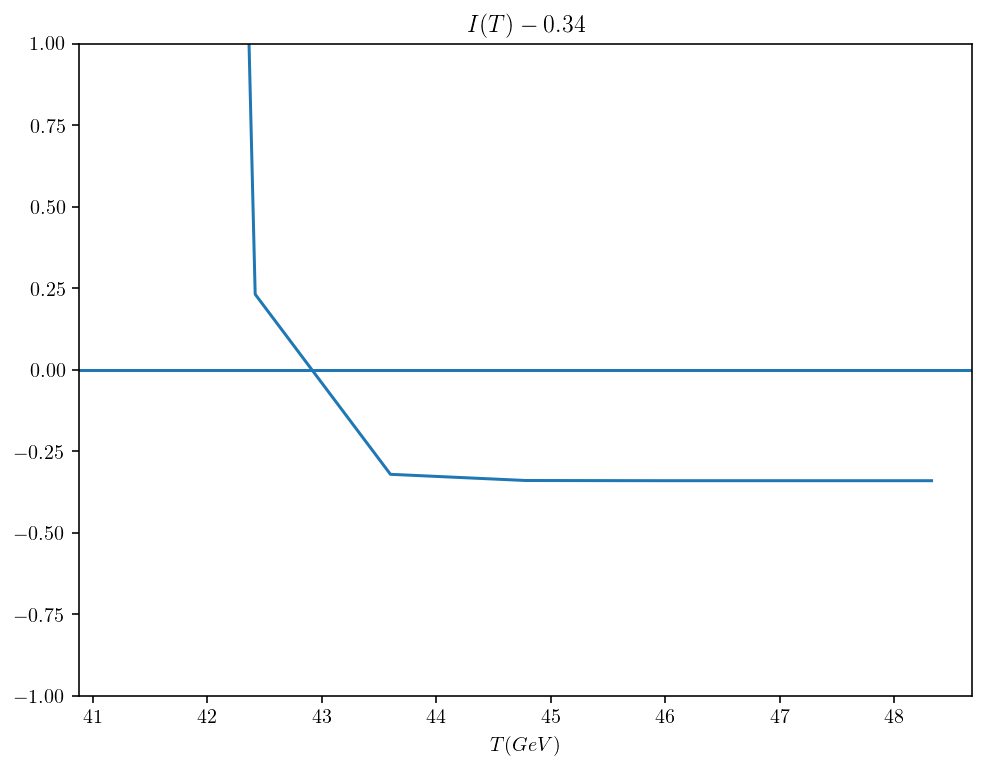

Tunneling from phase 2 to phase 0 at T=42.91473
high_vev = [-5.97635367e-07  9.63177772e-01]
low_vev = [245.1805375  138.07741858]
Path deformation converged. 35 steps. fRatio = 1.86636e-02
Path deformation converged. 14 steps. fRatio = 1.88770e-02
Path deformation converged. 1 steps. fRatio = 2.18433e-02
Tunneling from phase 2 to phase 0 at T=25.90022
high_vev = [-3.87268376e-05  8.26616963e-01]
low_vev = [246.12229168 138.14127322]
Path deformation converged. 36 steps. fRatio = 1.76953e-02
Path deformation converged. 17 steps. fRatio = 1.01717e-02
Path deformation converged. 4 steps. fRatio = 8.33400e-03
Path deformation converged. 1 steps. fRatio = 4.23369e-03
Tunneling from phase 2 to phase 0 at T=25.90072
high_vev = [-3.58122283e-05  8.26619204e-01]
low_vev = [246.12228369 138.1412734 ]
Path deformation converged. 36 steps. fRatio = 1.76951e-02
Path deformation converged. 17 steps. fRatio = 1.01887e-02
Path deformation converged. 4 steps. fRatio = 9.86906e-03
Path deformation conv

In [30]:

#df=pd.read_csv("SCANS/BAU/Z2_breaking_sols_BAU_All.csv",index_col=[0]).sort_values("alpha_max").drop_duplicates()
df=pd.read_csv("SCANS/On_Shell_STRONG_1.csv",index_col=[0]).sort_values("alpha_max").drop_duplicates()


modi=np.random.randint(0,len(df))
modi=-15
print(modi)


num_points=1
for l in range(num_points):
    ms_val=df.iloc[modi]["ms"]
    theta_val=df.iloc[modi]["theta"]
    u_val=df.iloc[modi]["u"]
    mu3_val=df.iloc[modi]["mu3"]
    muhs_val=df.iloc[modi]["muhs"]
    m=model1(ms = ms_val, theta = theta_val,muhs= muhs_val ,u = u_val,mu3 = mu3_val)

    m.print_couplings()
    thbool=m.theory_consistent()
    EWSBbool=m.isEWSB() 
    Pih=g1**2/16 + 3*g**2/16 + m.lamh/2 + 1/4 + m.lammix/24
    Pis=m.lammix/6 + m.lams/4
    lamh_tilde=m.lamh - m.lammix**2/4/m.lams
    dict_out={'ms':m.ms,'theta':m.theta, 'u':m.u,"muhs":m.muhs,"mu3":m.mu3,
              "lamh":m.lamh,"lams":m.lams,"lammix":m.lammix,
              "muh2":m.muh2,"mus2":m.mus2,
              "Pih":Pih,"Pis":Pis,"lamh_tilde":lamh_tilde}
    dict_out.update({ "th_bool":thbool and EWSBbool})
    #---------Theoretical consistency
    if dict_out["th_bool"]==False:
        continue
     
    nuc_dicts=find_nucleation(m)
    phases_copy=m.phases.copy()
    if len(nuc_dicts)==0:
        continue
    else:
        num_dicts=len(nuc_dicts)
    dict_out.update({"num_FOPT":num_dicts})    

    for nuc_dict in nuc_dicts: 
        try:
            ###Parameters at nucleation temperature------------------------------------------------------------
            dict_out.update({"Tc_"+str(nuc_dicts.index(nuc_dict)):nuc_dict["Tmax"],
                             "Tmin_"+str(nuc_dicts.index(nuc_dict)):nuc_dict["Tmin"]})
            
            relevant_phases={nuc_dict["high_phase"]:m.phases[nuc_dict["high_phase"]],nuc_dict["low_phase"]:m.phases[nuc_dict["low_phase"]]}
            m.phases=relevant_phases
            #Tnuc=optimize.fminbound(nucleation_temp,nuc_dict["Tmin"],nuc_dict["Tmax"])
            #fun_nucleation=lambda T: (Gamma(T)/Hubble_total(T)**4-1.)**4
            #if nuc_dict["Tmin"]<1:
            #    Tnuc=optimize.fminbound(fun_nucleation,np.mean([nuc_dict["Tmin"]+1e-3,nuc_dict["Tmax"]]),nuc_dict["Tmax"])
            #else:
            #    Tnuc=optimize.fminbound(fun_nucleation,nuc_dict["Tmin"]+1e-3,nuc_dict["Tmax"])                
            #dict_out.update({'Tnuc_'+str(nuc_dicts.index(nuc_dict)): Tnuc})
            
            #S_nuc=my_Action(Tnuc)
            #dict_out.update({"action_Tn_"+str(nuc_dicts.index(nuc_dict)):S_nuc*Tnuc})
            
            #check_nucleation=abs(Gamma_Hubble4(S_nuc*Tnuc,Tnuc)/Hubble_total(Tnuc)**4-1)<1e-3
            #dict_out.update({"nucleation_bool_"+str(nuc_dicts.index(nuc_dict)):check_nucleation})
            nucleation= findTnuc()
            if nucleation[2]==False:
                m.phases=phases_copy
                continue
            else:
                Tnuc, S_nuc = nucleation[0], nucleation[1]
                dict_out.update({'Tnuc_'+str(nuc_dicts.index(nuc_dict)): Tnuc})
                dict_out.update({"action_Tn_"+str(nuc_dicts.index(nuc_dict)):S_nuc*Tnuc})
                

            m.findAllTransitions(tunnelFromPhase_args={"nuclCriterion":lambda S,T: S/(T+1e-100)-S_nuc})
            alltrans_Tnuc=m.TnTrans
            elem=alltrans_Tnuc[0] ###How many transitions??
            if abs(elem["action"]-S_nuc*Tnuc)>1 and abs(elem["Tnuc"]-Tnuc)>1:
                """check if all transitions indeed find the same S and T values"""
                m.phases=phases_copy
                continue
            dS_TdT_Tnuc=misc.derivative(S_profile, x0=Tnuc, dx=.01, n=1, args=(elem,),order=7)
            
            #--------vevs, energy density, pressure and wall velocity at Tnuc---------------------------------------------------------
            phi_stable_Tnuc=elem["low_vev"]
            dict_out.update({"h_low_Tnuc_"+str(nuc_dicts.index(nuc_dict)):phi_stable_Tnuc[0],
                             "s_low_Tnuc_"+str(nuc_dicts.index(nuc_dict)):phi_stable_Tnuc[1]})
            
            phi_meta_Tnuc=elem["high_vev"]
            dict_out.update({"h_high_Tnuc_"+str(nuc_dicts.index(nuc_dict)):phi_meta_Tnuc[0],
                             "s_high_Tnuc_"+str(nuc_dicts.index(nuc_dict)):phi_meta_Tnuc[1]})
            
            Delta_rho_Tnuc=m.energyDensity(phi_meta_Tnuc,Tnuc,include_radiation=True)-m.energyDensity(phi_stable_Tnuc,Tnuc,include_radiation=True)
            dict_out.update({"Delta_rho_Tnuc_"+str(nuc_dicts.index(nuc_dict)): Delta_rho_Tnuc})
            
            Delta_p_Tnuc=m.Vtot(phi_meta_Tnuc,Tnuc)-m.Vtot(phi_stable_Tnuc,Tnuc)
            dict_out.update({"Delta_p_Tnuc_"+str(nuc_dicts.index(nuc_dict)): Delta_p_Tnuc})
            
            alpha_Tnuc=alpha_GW(Tnuc,Delta_rho_Tnuc)
            dict_out.update({"alpha_Tnuc_"+str(nuc_dicts.index(nuc_dict)):alpha_Tnuc})
            
            beta_Tnuc=beta_GW(Tnuc,dS_TdT_Tnuc)
            dict_out.update({"beta_Tnuc_"+str(nuc_dicts.index(nuc_dict)):beta_Tnuc})
            
            xi_Jouguet=((alpha_Tnuc*(2+3*alpha_Tnuc))**0.5+1)/(3**0.5*(1+alpha_Tnuc))
            dV = m.Vtot(phi_meta_Tnuc,Tnuc)-m.Vtot(phi_stable_Tnuc,Tnuc)
            radiationDensity=np.pi**2/30*g_star(Tnuc)*Tnuc**4
            vwall=(dV/alpha_Tnuc/radiationDensity)**0.5 ##Analytic formula
            dict_out.update({"vwall_"+str(nuc_dicts.index(nuc_dict)): vwall,
                             "xi_Jouguet_"+str(nuc_dicts.index(nuc_dict)):xi_Jouguet}) 
            
            my_signal_Tnuc=GW_signal(Tnuc*(1+alpha_Tnuc)**0.25,alpha_Tnuc,beta_Tnuc,1)
            peak_vals_Tnuc=my_signal_Tnuc.T[my_signal_Tnuc[1]==max(my_signal_Tnuc[1])][0] ##Extract values at peak
            f_peak_Tnuc=peak_vals_Tnuc[0]
            Omega_peak_Tnuc=peak_vals_Tnuc[1]
            dict_out.update({"f_peak_Tnuc_"+str(nuc_dicts.index(nuc_dict)): f_peak_Tnuc,
                        "Omega_peak_Tnuc_"+str(nuc_dicts.index(nuc_dict)):Omega_peak_Tnuc})
            #SNR_Tnuc=SNR_GW(Tnuc*(1+alpha_Tnuc)**0.25,alpha_Tnuc,beta_Tnuc,1)
            #dict_out.update({"SNR_Tnuc_"+str(nuc_dicts.index(nuc_dict)): SNR_Tnuc})
            SNR_Tnuc=SNR_GW(my_signal_Tnuc)
            dict_out.update({"SNR_Tnuc_"+str(nuc_dicts.index(nuc_dict)): SNR_Tnuc})
            
            ##Parameters at PERCOLATION temperature Tp-------------------------------------- 
            Tp,volume_shrinks=T_percolation(20,vwall)
            dict_out.update({"Tp_"+str(nuc_dicts.index(nuc_dict)):Tp,
                             "volume_shrinks_"+str(nuc_dicts.index(nuc_dict)):volume_shrinks})
            
            S_p=my_Action(Tp)
            dict_out.update({"action_Tp_"+str(nuc_dicts.index(nuc_dict)):S_p*Tp})
            
            m.findAllTransitions(tunnelFromPhase_args={"nuclCriterion":lambda S,T: S/(T+1e-100)-S_p})
            alltrans_Tp=m.TnTrans
            elem=alltrans_Tp[0] ###How many transitions??
            if abs(elem["action"]-S_p*Tp)>1 and abs(elem["Tnuc"]-Tp)>1:
                """check if all transitions indeed finds the same S and T values"""
                m.phases=phases_copy
                continue
            dS_TdT_Tp=misc.derivative(S_profile, x0=Tp, dx=.01, n=1, args=(elem,),order=7)

            
            #-------vevs, energy density and pressure at Tp--------------------------------
            phi_stable_Tp=elem["low_vev"]
            dict_out.update({"s_low_Tp_"+str(nuc_dicts.index(nuc_dict)):phi_stable_Tp[1],
                             "h_low_Tp_"+str(nuc_dicts.index(nuc_dict)):phi_stable_Tp[0]})
            
            phi_meta_Tp=elem["high_vev"]
            dict_out.update({"s_high_Tp_"+str(nuc_dicts.index(nuc_dict)):phi_meta_Tp[1],
                             "h_high_Tp_"+str(nuc_dicts.index(nuc_dict)):phi_meta_Tp[0]})
            
            Delta_rho_Tp=m.energyDensity(phi_meta_Tp,Tp,include_radiation=True)-m.energyDensity(phi_stable_Tp,Tp,include_radiation=True)
            dict_out.update({"Delta_rho_Tp_"+str(nuc_dicts.index(nuc_dict)): Delta_rho_Tp})
            
            Delta_p_Tp=m.Vtot(phi_meta_Tp,Tp)-m.Vtot(phi_stable_Tp,Tp)
            dict_out.update({"Delta_p_Tp_"+str(nuc_dicts.index(nuc_dict)): Delta_p_Tp})
            
            alpha_Tp=alpha_GW(Tp,Delta_rho_Tp)
            dict_out.update({"alpha_Tp_"+str(nuc_dicts.index(nuc_dict)):alpha_GW(Tp,Delta_rho_Tp)})
            
            beta_Tp=beta_GW(Tp,dS_TdT_Tp)
            dict_out.update({"beta_Tp_"+str(nuc_dicts.index(nuc_dict)):beta_Tp})
            
            xi_Jouguet_Tp=((alpha_Tp*(2+3*alpha_Tp))**0.5+1)/(3**0.5*(1+alpha_Tp))
            dV_Tp = m.Vtot(phi_meta_Tp,Tp)-m.Vtot(phi_stable_Tp,Tp)
            radiationDensity_Tp=np.pi**2/30*g_star(Tp)*Tp**4
            vwall_Tp=(dV_Tp/alpha_Tp/radiationDensity_Tp)**0.5 ##Analytic formula
            dict_out.update({"vwall_Tp_"+str(nuc_dicts.index(nuc_dict)): vwall_Tp,
                             "xi_Jouguet_Tp_"+str(nuc_dicts.index(nuc_dict)):xi_Jouguet_Tp})
            
            my_signal_Tp=GW_signal(Tp*(1+alpha_Tp)**0.25,alpha_Tp,beta_Tp,vwall_Tp)
            peak_vals_Tp=my_signal_Tp.T[my_signal_Tp[1]==max(my_signal_Tp[1])][0] ##Extract values at peak
            f_peak_Tp=peak_vals_Tp[0]
            Omega_peak_Tp=peak_vals_Tp[1]
            dict_out.update({"f_peak_Tp_"+str(nuc_dicts.index(nuc_dict)): f_peak_Tp,
                             "Omega_peak_Tp_"+str(nuc_dicts.index(nuc_dict)):Omega_peak_Tp})
            #SNR_Tp=SNR_GW(Tp*(1+alpha_Tp)**0.25,alpha_Tp,beta_Tp,vwall)
            SNR_Tp=SNR_GW(my_signal_Tp)
            dict_out.update({"SNR_Tp_"+str(nuc_dicts.index(nuc_dict)): SNR_Tp})
            
            #-----Fill dictionary------------------------------------------------------------
            print("\n ..........\n Current dictionary is: \n")
            print(dict_out)
        except:
            print("error ocurred")
            m.phases=phases_copy
            continue

In [31]:
nucleation

(48.32663894360973, 153.46539996037242, True)

In [32]:
dict_out

{'ms': 130.58690892147837,
 'theta': -0.02057874876051395,
 'u': 138.14540209753923,
 'muhs': -127.29650034376932,
 'mu3': 459.8860354450589,
 'lamh': 0.12907900489972074,
 'lams': 1.3795836447601408,
 'lammix': 0.9223176380260567,
 'muh2': -960.5495740029783,
 'mus2': -37177.192272365704,
 'Pih': 0.4374708859463563,
 'Pis': 0.4986155175277113,
 'lamh_tilde': -0.0250743566316608,
 'th_bool': True,
 'num_FOPT': 1,
 'Tc_0': 96.73731541748785,
 'Tmin_0': 25.877466951992446,
 'Tnuc_0': 48.32663894360973,
 'action_Tn_0': 7416.466974221577,
 'h_low_Tnuc_0': 244.45658599584908,
 's_low_Tnuc_0': 138.0279963664036,
 'h_high_Tnuc_0': 7.621370190906419e-06,
 's_high_Tnuc_0': 1.0438560017669885,
 'Delta_rho_Tnuc_0': 49403257.35538727,
 'Delta_p_Tnuc_0': 43520142.82183673,
 'alpha_Tnuc_0': 0.29683450641279246,
 'beta_Tnuc_0': 152.84929159328766,
 'vwall_0': 0.9385715022602944,
 'xi_Jouguet_0': 0.8575807563795093,
 'f_peak_Tnuc_0': 0.0010109909909909911,
 'Omega_peak_Tnuc_0': 1.9693700963737543e-12,

In [33]:
##Plot the nucleation rate and Hubble constant as function of Temperature
# Temp_range=np.linspace(nuc_dict["Tmin"],nuc_dict["Tmax"])
# 
# H_tot=[]
# Gam=[]
# for Ti in Temp_range:
#     H_tot.append(Hubble_total(Ti)**4)
#     Gam.append(Gamma(Ti))
# 
# plt.plot(Temp_range,Gam,label="$\\Gamma(T)$")
# plt.plot(Temp_range,Hubble_radiation(Temp_range)**4)
# plt.plot(Temp_range,H_tot,linestyle="--")
# plt.legend()
# plt.yscale("log")


In [34]:
dict_out["Tnuc_0"],dict(df.iloc[modi])["Tnuc_0"]

(48.32663894360973, 43.79064500191368)

In [35]:
mod_dict=dict(df.iloc[modi])
dict_out.keys(),mod_dict.keys()


(dict_keys(['ms', 'theta', 'u', 'muhs', 'mu3', 'lamh', 'lams', 'lammix', 'muh2', 'mus2', 'Pih', 'Pis', 'lamh_tilde', 'th_bool', 'num_FOPT', 'Tc_0', 'Tmin_0', 'Tnuc_0', 'action_Tn_0', 'h_low_Tnuc_0', 's_low_Tnuc_0', 'h_high_Tnuc_0', 's_high_Tnuc_0', 'Delta_rho_Tnuc_0', 'Delta_p_Tnuc_0', 'alpha_Tnuc_0', 'beta_Tnuc_0', 'vwall_0', 'xi_Jouguet_0', 'f_peak_Tnuc_0', 'Omega_peak_Tnuc_0', 'SNR_Tnuc_0', 'Tp_0', 'volume_shrinks_0', 'action_Tp_0', 's_low_Tp_0', 'h_low_Tp_0', 's_high_Tp_0', 'h_high_Tp_0', 'Delta_rho_Tp_0', 'Delta_p_Tp_0', 'alpha_Tp_0', 'beta_Tp_0', 'vwall_Tp_0', 'xi_Jouguet_Tp_0', 'f_peak_Tp_0', 'Omega_peak_Tp_0', 'SNR_Tp_0']),
 dict_keys(['ms', 'theta', 'u', 'muhs', 'mu3', 'lamh', 'lams', 'lammix', 'muh2', 'mus2', 'Pih', 'Pis', 'lamh_tilde', 'th_bool', 'h_low_0', 's_low_0', 'h_high_0', 's_high_0', 'Tnuc_0', 'dT_0', 'alpha_0', 'vwf_0', 'xi_J_0', 'v_calculable_0', 'num_FOPT', 'alpha_max', 'dT_max', 'tran_type', 'h_low_1', 's_low_1', 'h_high_1', 's_high_1', 'Tnuc_1', 'dT_1', 'alpha_1

In [46]:
dict_out["vwall_Tp_0"],dict_out["vwall_0"]

(0.9576454052816078, 0.9385715022602944)

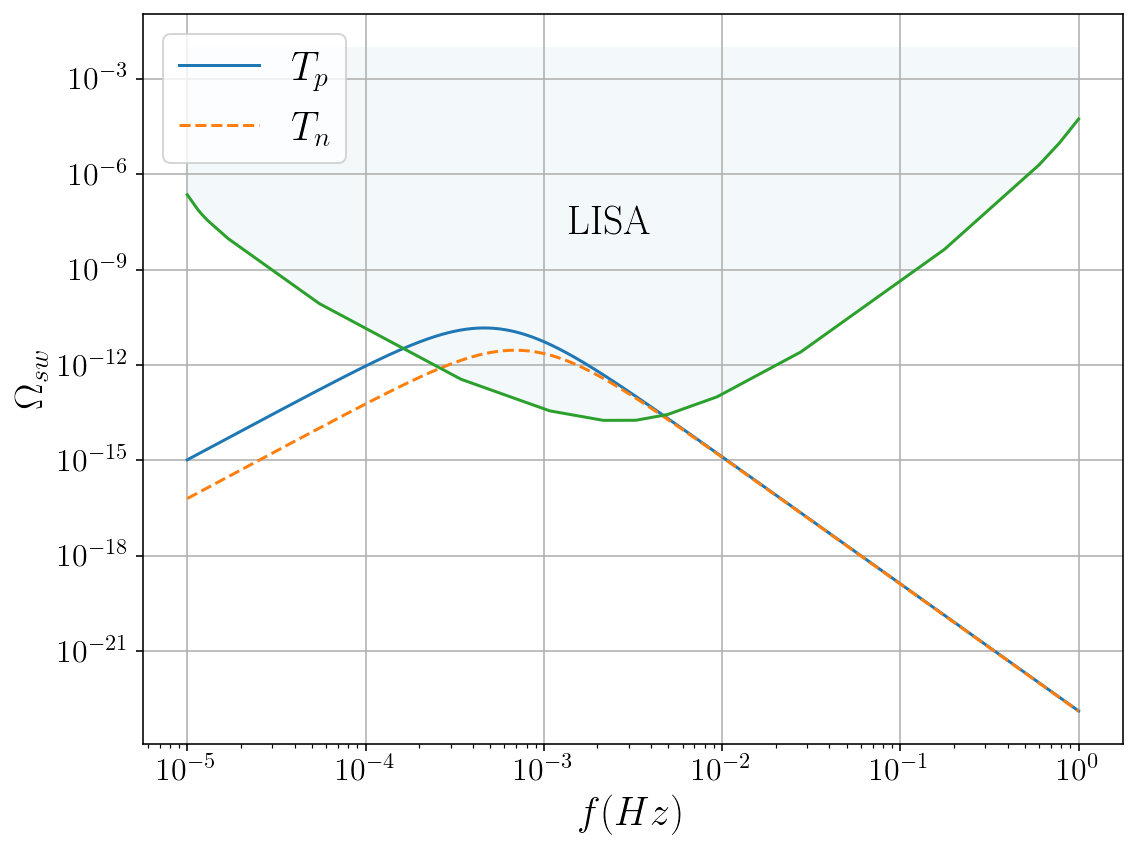

In [66]:
Temp, alpha, beta, vel=dict_out["Tp_0"],dict_out["alpha_Tp_0"],dict_out["beta_Tp_0"],dict_out["vwall_0"]
my_signal=GW_signal(Temp, alpha, beta, vel)
Temp, alpha, beta, vel=dict_out["Tnuc_0"],dict_out["alpha_Tnuc_0"],dict_out["beta_Tnuc_0"],dict_out["vwall_0"]
my_signal_1=GW_signal(Temp, alpha, beta, vel)

thick_size=16
label_size=20

plt.plot(my_signal[0],my_signal[1],label="$T_p$")
plt.plot(my_signal_1[0],my_signal_1[1],linestyle="--",label="$T_n$")
plt.plot(LISA_curve.f,LISA_curve.Omega_lim)
plt.fill_between(LISA_curve.f, LISA_curve.Omega_lim, 1e-2, alpha=0.05)
plt.figtext(.5, .72, "LISA", fontsize=label_size)

plt.xlabel("$f(Hz)$",size=label_size)
plt.ylabel("$\\Omega_{sw}$",size=label_size)
plt.xscale("log")
plt.yscale("log")           
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.legend(prop={'size': label_size})


#plt.legend(prop={'size': label_size})
plt.tight_layout()
#plt.savefig('SCANS/bubble_PLOTS/Sphaleron.pdf', dpi=300)